In [1]:
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
import pickle as pkl
sys.path.append('..')

import data
import style
import config
from config import *
import util
import glob
import json, jsonlines

df = data.load_all_labs()
df = df.set_index('fname_id')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fname_ids = np.array([f[:-4] for f in fname_nps])
idxs_calculated = np.array([int(x) - 1 for x in fname_ids]) # this starts at 0

# trim df to only have the relevant ids
df = df.loc[fname_ids]

# select celebrities

In [2]:
# only consider ids with more than 2 ims
d = df[df['count_with_this_id'] > 2]

# sort by how many ids each image has
d = d.sort_values('count_with_this_id', ascending=False)

# get ids for subgroups
subgroups = {}
for gender in [0, 1]:
    for race in ['Black', 'White']:
        dd = d[d['gender'] == gender]
        dd = dd[dd['race_pred'] == race]
        print(gender, race, '|', dd.id.unique().size, 'ids\t', dd.shape[0], 'photos')        
        subgroups[(gender, race)] = dd.id.unique()

def pair_plot(im0, im1):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.title('Real photo')
    util.imshow(im0)
    plt.subplot(R, C, 2)
    plt.title('Test photo')
    util.imshow(im1)
    plt.tight_layout()
    
def slight_random_crop(im):
    x = np.random.randint(20, 35)
    return im[x: -x, x: -x]

0 Black | 91 ids	 468 photos
0 White | 1468 ids	 8536 photos
1 Black | 157 ids	 570 photos
1 White | 842 ids	 3608 photos


In [ ]:
np.random.seed(13)
N_IMS = 30
EXPERIMENT_DIR = oj(DIR_PROCESSED, 'projections_annotation_double', 'ims')
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
for gender, race in tqdm(subgroups.keys()):
    # print(gender, race)
    ids = subgroups[(gender, race)]
    for i in tqdm(ids[:N_IMS]):
        ims = d[d.id == i].iloc[:2]
        im0 = mpimg.imread(oj(DIR_IMS, ims.fname_final.values[0]))
        im1 = mpimg.imread(oj(DIR_IMS, ims.fname_final.values[1]))
        im1_rec = mpimg.imread(oj(DIR_GEN, ims.fname_final.values[1][:-4] + '.png'))
        pair_plot(im0, im1)
        plt.savefig(oj(EXPERIMENT_DIR, f'{gender}_{race}_{i}_real.png'), dpi=300)
        pair_plot(im0, im1_rec)
        plt.savefig(oj(EXPERIMENT_DIR, f'{gender}_{race}_{i}_fake.png'), dpi=300)
        pair_plot(im0, slight_random_crop(im0))
        plt.savefig(oj(EXPERIMENT_DIR, f'{gender}_{race}_{i}_dup.png'), dpi=300)        

In [ ]:
len(os.listdir(oj(DIR_PROCESSED, 'projections_annotation_double', 'ims')))

# analyze results

In [2]:
ANNOTATIONS_DIR = DIR_PROJ_ANNOTATIONS
LABELS_FILE = '/annotation-tool/data.json'
OUT_MANIFEST_FILE = '/manifests/output/output.manifest'
WORKERS_RESPONSE = '/annotations/worker-response'
OUTPUT_PDF_DIR = './figures' # location of output pdfs


sys.path.append(oj(DIR_REPO, 'disentangling_latent_space'))
from annotation_dset import annotationDatabase

In [76]:
# Get list of experiments in annotation dir. Alternatively, specify ones you care about.
annotations_dict = {}
annotations_names_dict = {}
experiments = [os.path.split(f)[1] for f in glob.glob(os.path.join(ANNOTATIONS_DIR, '*'))]
print('experiments', experiments)
experiments = ['.'] #'perona-causal-faces-uncanny-000']

# If output directory doesn't exist, make it
if not os.path.exists(OUTPUT_PDF_DIR):
    os.makedirs(OUTPUT_PDF_DIR)

# Do analysis figures for each experiment
for EXPERIMENT_LABEL in experiments:
    ANNOTATIONS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{WORKERS_RESPONSE}'
    OUT_MANIFEST_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{OUT_MANIFEST_FILE}'
    LABELS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{LABELS_FILE}'
    OUT_PDF_FILE_NAME = os.path.join(OUTPUT_PDF_DIR, EXPERIMENT_LABEL + '.pdf')

    #Read labels using annotation-tool/data.json and assign integers to labels 
    with open(LABELS_PATH, 'r') as labels_file:
        labels_data = json.load(labels_file)['labels']
        LABELS = [l['label'] for l in labels_data]
    # labelScores = {l:i for (i, l) in enumerate(LABELS)} # generate numerical scores for the labels - useful in regression
    labelScores = {l:l for (i, l) in enumerate(LABELS)} # generate numerical scores for the labels - useful in regression

    # Get ordered list of image names from output manifest
    image_names = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
            image_names.append(name)

    # Make map from annotation index to image index
    idx_map = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
#             print(name)
            idx = name.split('.')[0]
            idx_map.append(idx)

    # Make annotation file name list in proper order (keep same order)
    annotation_file_names = []
    for i in range(len(idx_map)):
        annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% i)


        
    # put together the database of the annotator IDs and their work
    annotations = annotationDatabase(annotation_file_names, labelScores, label_type='crowd-image-classifier-multi-select')
    annotations.startPDFReport(OUT_PDF_FILE_NAME, EXPERIMENT_LABEL)
    fig = annotations.displayAnnotatorsWork()
#     annotations.displaySequenceAnnotations(image_names, LABELS, SEQUENCE_LENGTH, IMAGE_PATH)
    annotations.endPDFReport()
    
    print(LABELS, np.array(annotations.imageScores).shape)
    annotations_dict[EXPERIMENT_LABEL] = np.array(annotations.imageScores)
    annotations_names_dict[EXPERIMENT_LABEL] = LABELS

mat_list = annotations_dict['.']
print('saved!')

experiments ['intermediate', 'annotation-tool', 'annotations', 'manifests', 'ims']
Found 360 images and 76 annotators.
['Same person', 'Not same person', '-------------', 'Well', 'Moderately well', 'Not at all'] (360, 3)
saved!


## num annotators plot

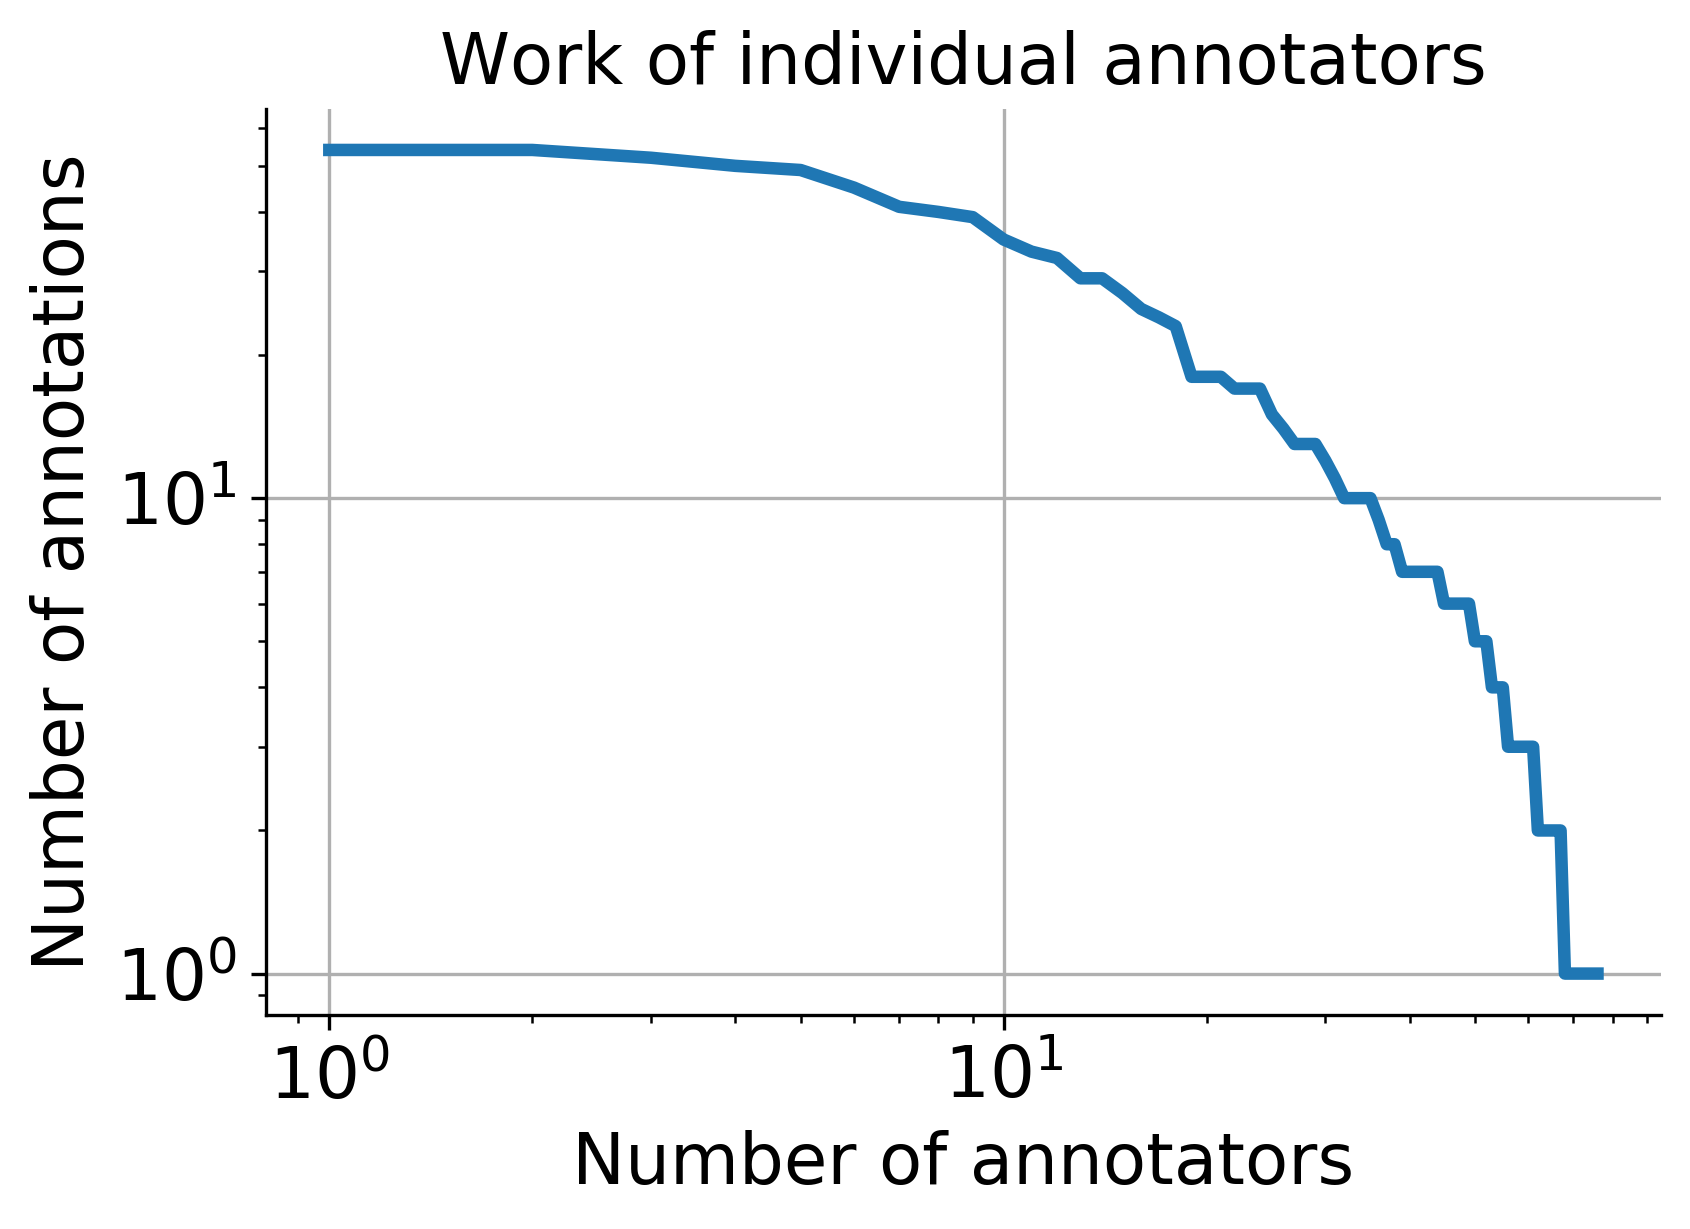

In [77]:
n_annotations = sorted(annotations.annotations, reverse=True)
plt.figure(dpi=300)
plt.grid()
plt.plot(range(1, 1 + annotations.N_ANNOTATORS), n_annotations)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of annotators')
plt.ylabel('Number of annotations')
plt.title('Work of individual annotators')
plt.show()

In [78]:
def same_or_not(l):
    if 'Same person' in l:
        return True
    elif 'Not same person' in l:
        return False
    else:
        return np.nan
def knows_well(l):
    if 'Well' in l:
        return 1
    elif 'Moderately well' in l:
        return 2
    elif 'Not at all' in l:
        return 3
    else:
        return np.nan
sames_mat = np.vectorize(same_or_not)(mat_list) # n x 3
knows_mat = np.vectorize(knows_well)(mat_list) # n x 3
# np.sum(np.isnan(knows)) / knows.size
# knows_mat[np.isnan(knows_mat)] = 3
means = np.mean(sames_mat * 1, axis=1)

print('inter-rater agreement (prob that 2 annotators agreed on a label)')
n_agrees = np.sum((sames_mat[:, 0] == sames_mat[:, 1])) + np.sum(sames_mat[:, 0] == sames_mat[:, 2]) + np.sum(sames_mat[:, 1] == sames_mat[:, 2])
print(n_agrees, f'{n_agrees / sames_mat.size:0.3f}')

inter-rater agreement (prob that 2 annotators agreed on a label)
796 0.737


## basic viz - dup vs fake/real

In [79]:
fnames = sorted([f for f in os.listdir(oj(DIR_PROCESSED, 'projection_annotations', 'ims'))
        if 'png' in f])
labs = {
    'race=black': list(map(lambda x: 'Black' in x, fnames)),
    'race=white': list(map(lambda x: 'White' in x, fnames)),    
    'female': list(map(lambda x: '0_' in x, fnames)),
    'male': list(map(lambda x: '1_' in x, fnames)),    
    'dup': list(map(lambda x: 'dup' in x, fnames)),
    'fake': list(map(lambda x: 'fake' in x, fnames)),
    'real': list(map(lambda x: 'real' in x, fnames)),
}
labs = pd.DataFrame.from_dict(labs)

def hist_subgroups(means, labs, labs_list, BINS=4):
    for lab in labs_list:
        plt.hist(means[labs[lab]], BINS, alpha=0.5, label=lab)
    plt.ylabel('Count')
    plt.xlabel('Fraction of images said to be "Same"')
    plt.legend()
    plt.show()

def boxplot_subgroups(vals, labs, labs_list, confs='sem', ret=False, width=7):
    '''
    vals: array_like
        what to plot
    labs: dataframe / dict
        contains indexes over which to extract the vals
    labs_list: array_like
        labels for the means
    confs: array_like
        confidence intervals
    '''
    plt.figure(dpi=300, figsize=(width, 3))
    lists = [vals[labs[lab]] for lab in labs_list]
    ys = np.arange(1, len(labs_list) + 1)
    if confs is None:
        plt.boxplot(lists, vert=False, showmeans=True)
    else:
        means = [np.mean(l) for l in lists]
        sem = [1.96 * np.std(l) / np.sqrt(len(l)) for l in lists]
        plt.errorbar(means,
                     ys, xerr=sem,
                     linestyle='None', marker='o', ms=8)
        # plt.boxplot(lists, vert=False, showmeans=True)
    plt.yticks(ys, [x.capitalize() for x in labs_list])
    plt.xlabel('Fraction of pairs labelled as "Same"')
    plt.ylabel('True conditions')
    plt.xlim((0.3, 1.05))
    if ret:
        return np.array(means), np.array(sem)
        

def add_intersections(labs, l1, l2, drop_dup=False):
    ks = []
    for k1 in l1:
        for k2 in l2:
            k_full = f'{k1} ({k2})'
            labs[k_full] = np.array(labs[k1]) & np.array(labs[k2])
            if drop_dup:
                labs[k_full] &= np.array(~labs['dup'])
            ks.append(k_full)
    return labs, ks


l_type = ['dup', 'fake', 'real']
l_gender = ['female', 'male']
l_race = ['race=black', 'race=white']

## look at subgroups

In [80]:
sames = sames_mat.flatten(order='F')
knows = knows_mat.flatten(order='F')
labs_expanded = labs.append(labs, ignore_index=True).append(labs, ignore_index=True)
d = {
    'knows well': knows==1,
    'knows moderately well': knows == 2,
    'not at all': knows ==3
}
l_well = list(d.keys())
for k in l_well:
    labs_expanded[k] = d[k]

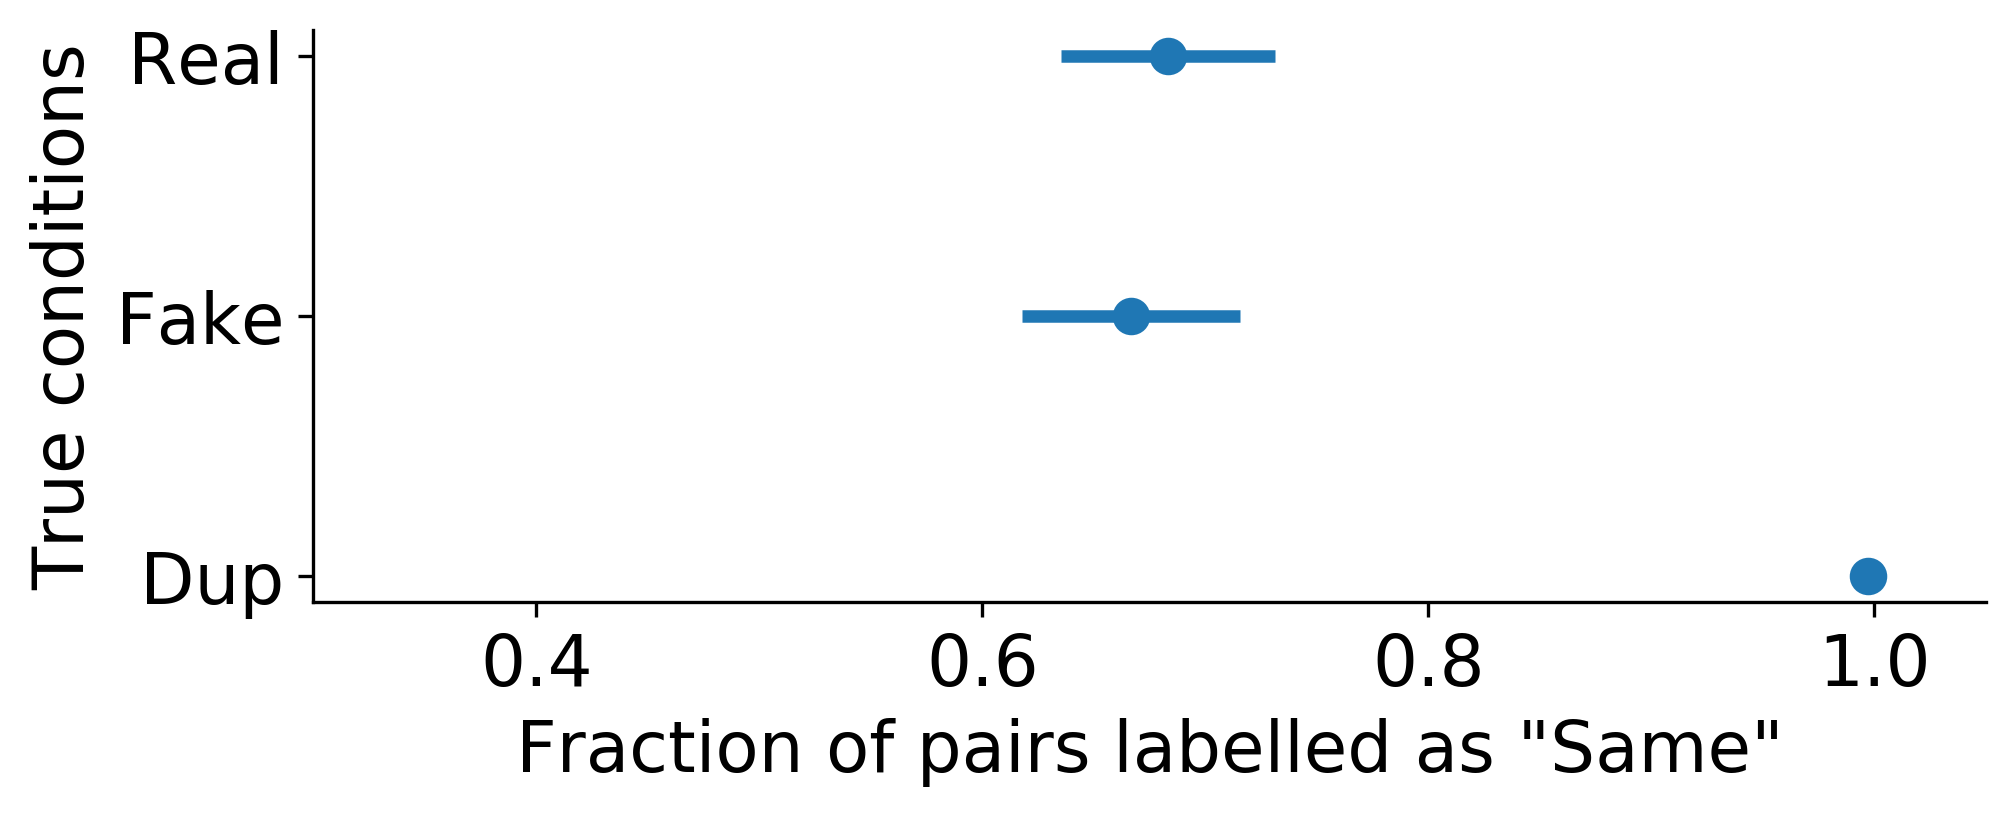

In [81]:
# fake vs real
means_tab, sems_tab = boxplot_subgroups(sames,
                  labs_expanded, l_type,
                  confs='sem', ret=True)
util.savefig('ann_main')

In [84]:
strs = np.array([f'{100 * means_tab[i]:0.1f} $\pm$ {100 * sems_tab[i]:0.2f}' for i in range(len(means_tab))])
d = pd.DataFrame(strs.reshape(1, -1)) #, columns) #, columns=l_non_dup)
d.columns = l_type
d

,dup,fake,real
0,99.7 $\pm$ 0.54,66.7 $\pm$ 4.87,68.3 $\pm$ 4.81


In [85]:
d = d[['fake', 'real']]
d = d.rename(columns={
    'fake': 'Fake pairs',
    'real': 'Real pairs'
})
print(d.to_latex(index=False).replace('textbackslash pm', 'pm').replace('\$', '$'))

\begin{tabular}{ll}
\toprule
      Fake pairs &       Real pairs \\
\midrule
 66.7 $\pm$ 4.87 &  68.3 $\pm$ 4.81 \\
\bottomrule
\end{tabular}



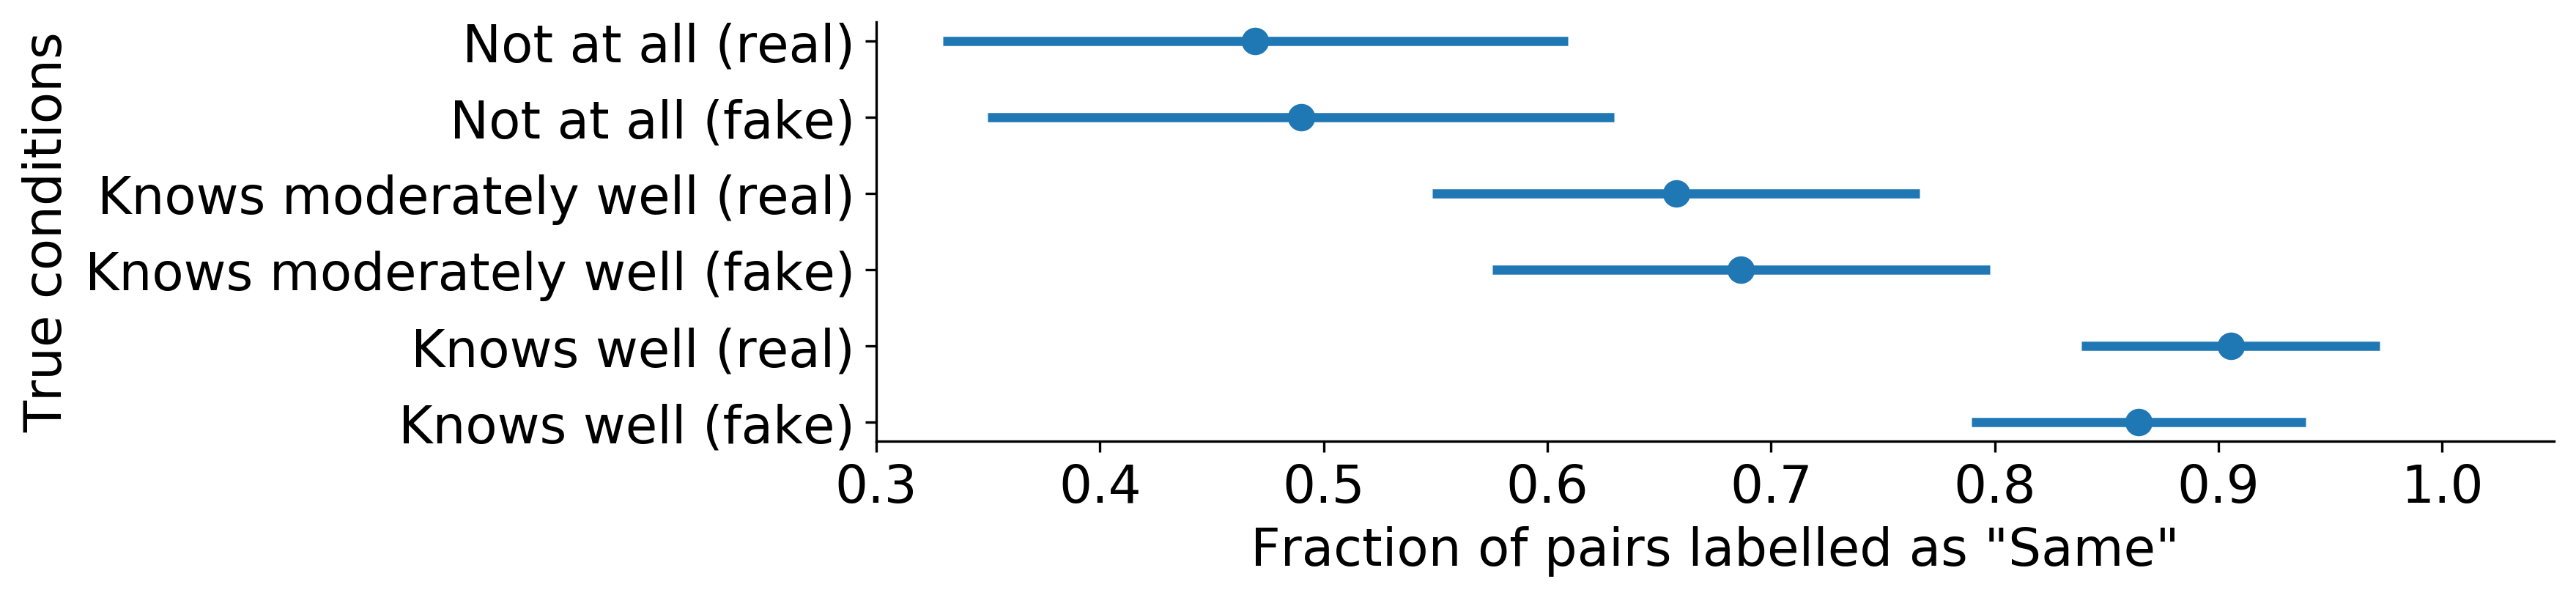

In [86]:
# fake vs real when considering knowledge of celeb
l_non_dup = [k for k in l_type if not 'dup' in k]
labs_expanded, ks = add_intersections(labs_expanded, l_well, l_non_dup)
boxplot_subgroups(sames, labs_expanded,
                  [k for k in ks if not 'dup' in k],
                  confs='sem',
                  width=12) #, confs=sames)
util.savefig('ann_knowledge')

Index(['race=black', 'race=white', 'female', 'male', 'dup', 'fake', 'real',
       'dup (female)', 'dup (male)', 'fake (female)', 'fake (male)',
       'real (female)', 'real (male)'],
      dtype='object') ['dup (female)', 'dup (male)', 'fake (female)', 'fake (male)', 'real (female)', 'real (male)']


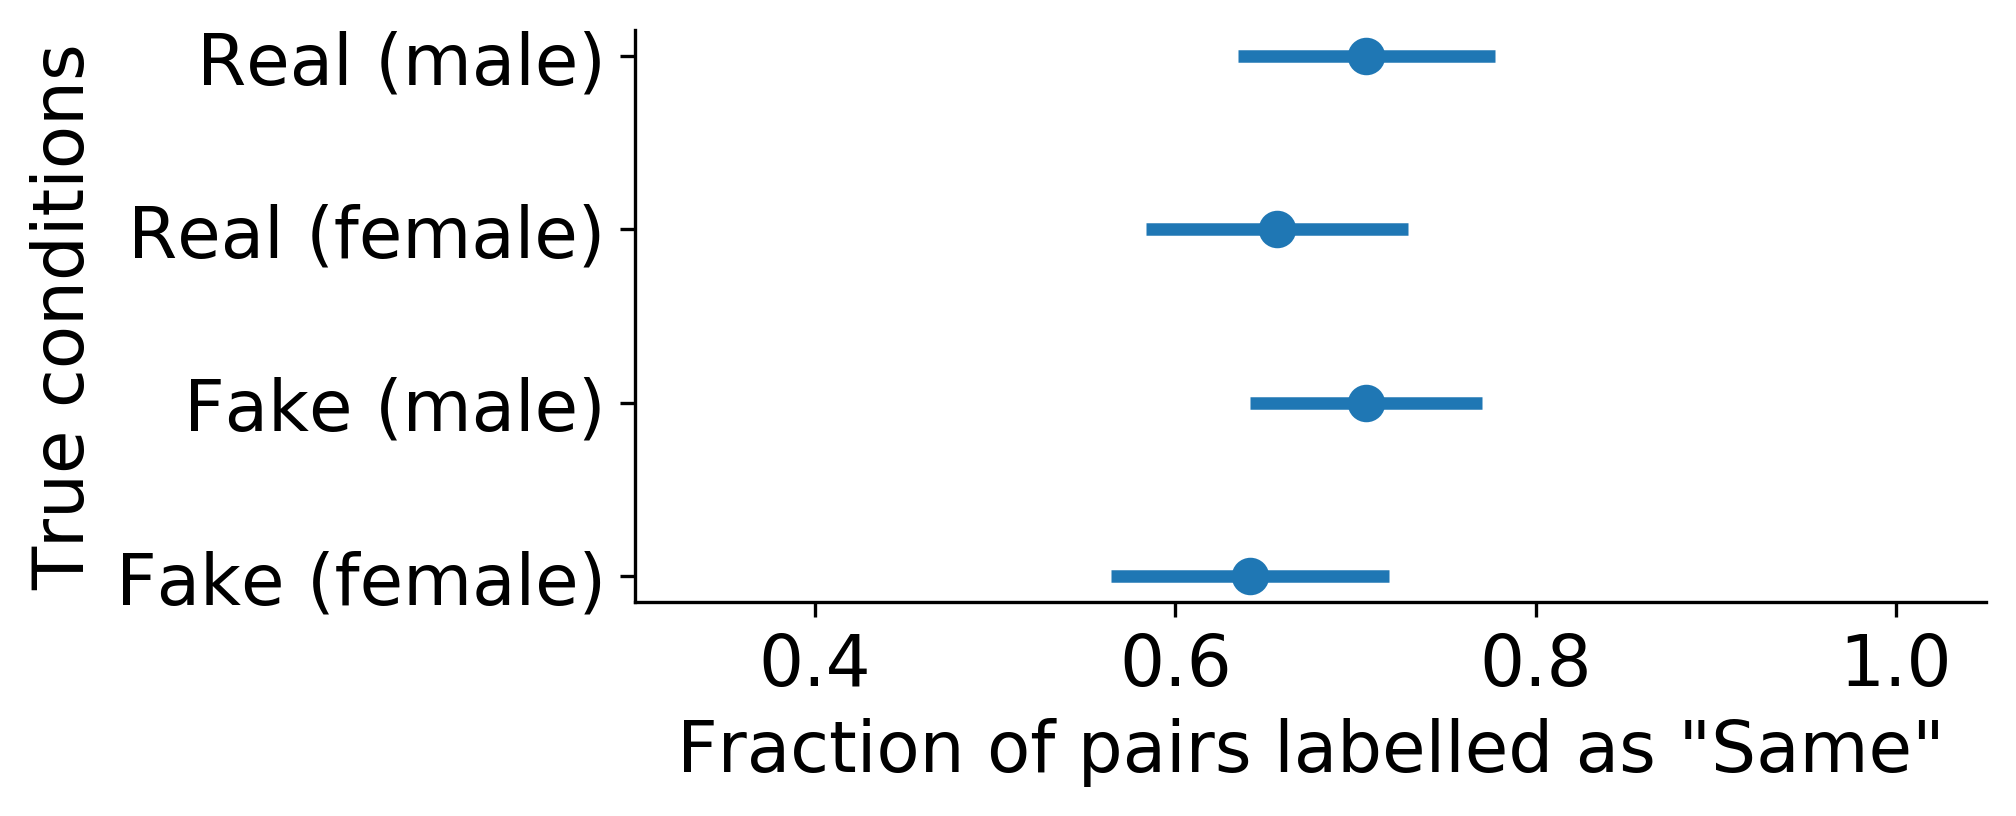

In [87]:
# fake vs real considering gender
labs, ks_type_gender = add_intersections(labs, l_type, l_gender)
print(labs.keys(), ks_type_gender)
lists = [means[labs[lab]] for lab in ks_type_gender]
boxplot_subgroups(means, labs,
                  [k for k in ks_type_gender if not 'dup' in k])
util.savefig('ann_gender')

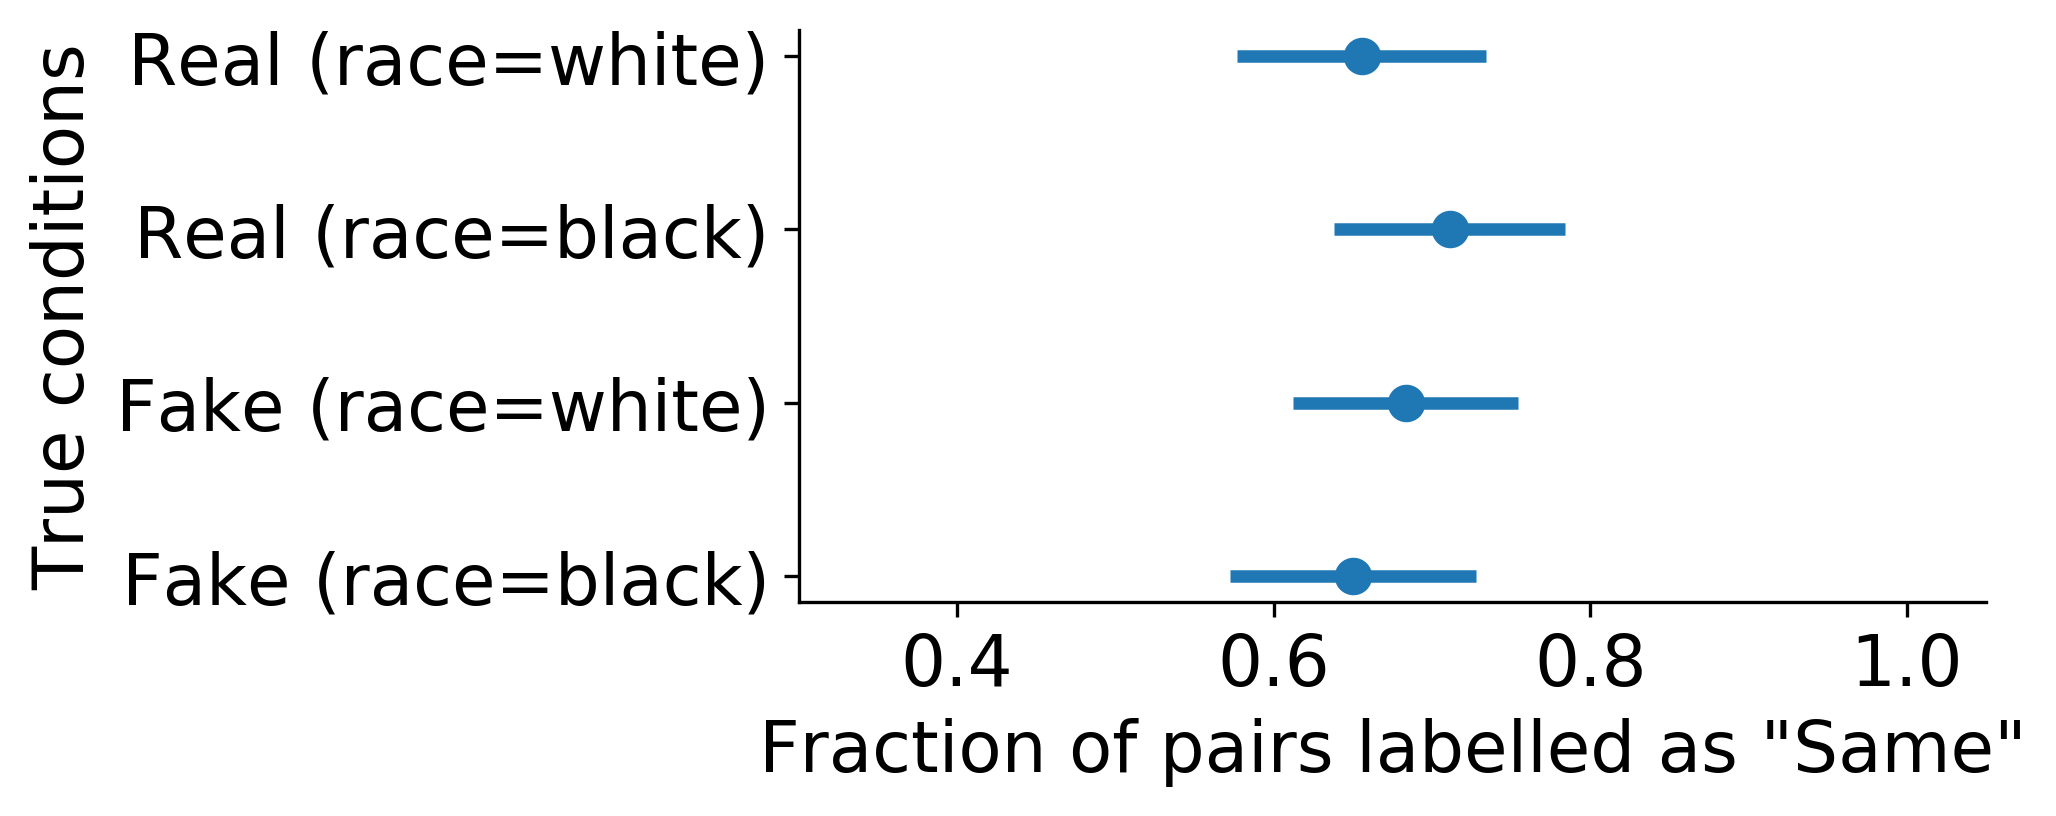

In [88]:
# fake vs real considering gender
labs, ks_type_race = add_intersections(labs, l_type, l_race)
boxplot_subgroups(means, labs,
                  [k for k in ks_type_race if not 'dup' in k])
util.savefig('ann_race')

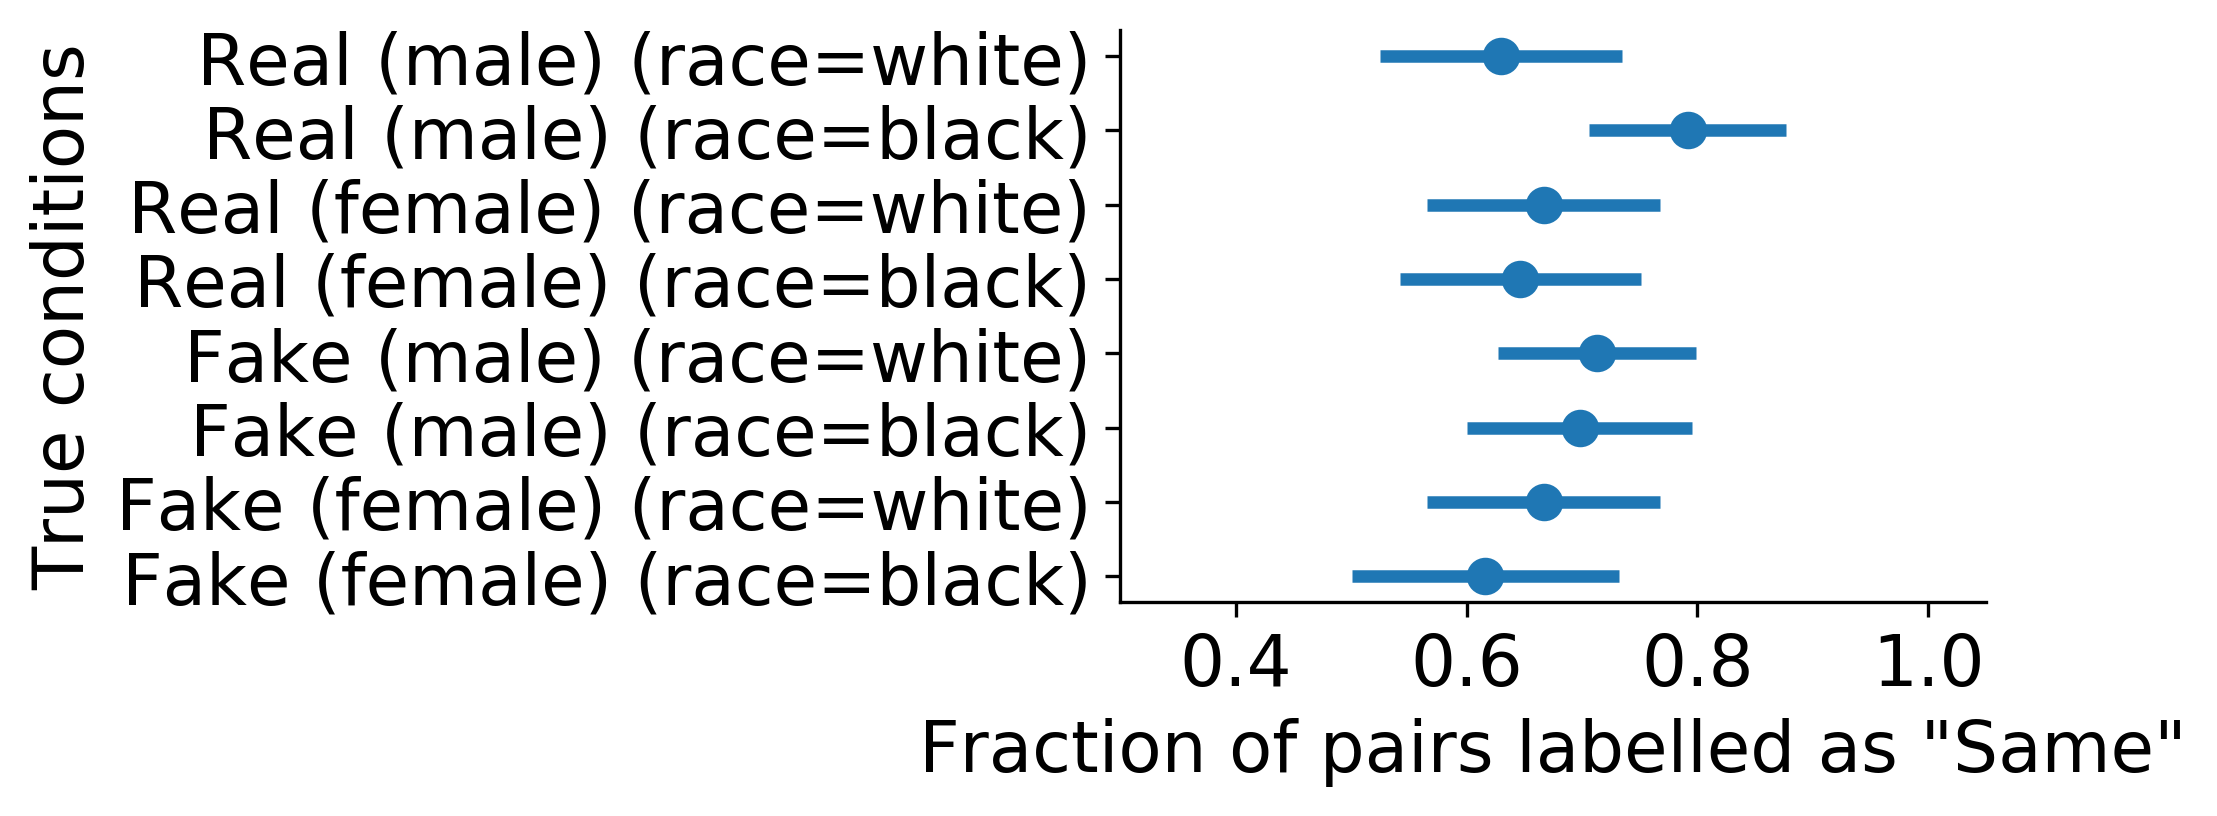

In [89]:
# fake vs real considering gender + race
labs, ks_intersect = add_intersections(labs, ks_type_gender, l_race)
boxplot_subgroups(means, labs,
                  [k for k in ks_intersect if not 'dup' in k])
util.savefig('ann_intersection')